## GroupLasso, Adaptive Lasso

In [ ]:
import pandas as pd
import numpy as np
from group_lasso import GroupLasso
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# 피처와 타겟 설정
X = train.drop('Target', axis=1)
y = train['Target']

# 그룹 설정 (예시로 그룹을 3개로 나눈다고 가정)
n_groups = 3
groups = np.concatenate([np.full(X.shape[1] // n_groups, i) for i in range(n_groups)])
groups = np.concatenate([groups, np.full(X.shape[1] - len(groups), n_groups-1)])  # 나머지 그룹 처리

# 피처 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group Lasso 모델 학습 및 5-fold 교차 검증
group_lasso_model = GroupLasso(groups=groups, fit_intercept=True, old_regularisation=True, tol=1e-4)

# MAE 평가를 위한 scorer 정의
mae_scorer = make_scorer(mean_absolute_error)

# Group Lasso 5-fold 교차 검증
group_lasso_scores = cross_val_score(group_lasso_model, X_scaled, y, cv=5, scoring=mae_scorer)
print(f'Group Lasso Mean Absolute Error (5-fold CV): {-np.mean(group_lasso_scores)} ± {np.std(group_lasso_scores)}')

# Adaptive Lasso 모델 학습 및 5-fold 교차 검증
# 초기 Lasso 모델로 계수 추정
initial_model = Lasso(alpha=0.1, random_state=42)
initial_model.fit(X_scaled, y)

# 각 계수에 대한 가중치 계산 (1/|coeff| 형태) - 0인 경우 처리
weights = np.zeros_like(initial_model.coef_)  # 초기화
for i, coef in enumerate(initial_model.coef_):
    if coef != 0:
        weights[i] = 1 / np.abs(coef)  # 0이 아닐 경우
    else:
        weights[i] = 0.01  # 0일 경우 0.01로 설정

# Adaptive Lasso 모델 학습 (가중치 적용)
adaptive_lasso_model = Lasso(alpha=0.1, random_state=42)

# Adaptive Lasso 5-fold 교차 검증 (가중치를 적용하여 피처를 조정)
adaptive_lasso_scores = cross_val_score(adaptive_lasso_model, X_scaled * weights, y, cv=5, scoring=mae_scorer)
print(f'Adaptive Lasso Mean Absolute Error (5-fold CV): {-np.mean(adaptive_lasso_scores)} ± {np.std(adaptive_lasso_scores)}')


Group Lasso Mean Absolute Error (5-fold CV): -12.541458574029678 ± 0.16327871226084678
Adaptive Lasso Mean Absolute Error (5-fold CV): -12.539553750625508 ± 0.16010837574502487


## 하이퍼파라미터 튜닝

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import optuna

# 데이터 로드
train = pd.read_csv('./train.csv')

# 연도를 2024로 설정하여 yymm 컬럼을 날짜 형식으로 변환
train['yymm'] = pd.to_datetime('2024' + train['yymm'], format='%Y%m%d %H:%M')

# day, hour, minute 컬럼 생성
train['day'] = train['yymm'].dt.day   # 일
train['hour'] = train['yymm'].dt.hour # 시
train['minute'] = train['yymm'].dt.minute # 분

# weekday 컬럼 생성 (요일 계산)
train['weekday'] = train['day'] % 7 # 1은 화요일, 2는 수요일, ...

# yymm 컬럼 삭제
train.drop('yymm', axis=1, inplace=True)

# 피처와 타겟 설정
X = train.drop('Target', axis=1)
y = train['Target']

# 훈련 세트와 검증 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 피처 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Optuna objective function
def objective(trial):
    # alpha 값을 Optuna에서 추천
    alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)  # 로그 스케일로 alpha 샘플링
    random_state = trial.suggest_int('random_state', 1, 10000)
    model = Lasso(alpha=alpha, random_state=random_state, max_iter=10000)  # max_iter 증가
    
    # 5-fold cross-validation을 통한 성능 평가
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    mean_score = -scores.mean()  # 평균 MAE
    
    return mean_score

# Optuna study 생성
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)  # 100번의 실험 수행

# 최적의 파라미터와 점수 출력
print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

# 최적의 파라미터로 모델 학습
best_model = Lasso(alpha=study.best_params['alpha'], random_state=study.best_params['random_state'], max_iter=10000)
best_model.fit(X_train, y_train)

# 훈련 데이터와 검증 데이터에 대한 예측
train_pred = best_model.predict(X_train)
val_pred = best_model.predict(X_val)
test_pred = best_model.predict(X_test)

# 5-fold 교차 검증으로 훈련 데이터 평가
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
train_score = -cv_scores.mean()  # 평균 MAE

val_score = mean_absolute_error(y_val, val_pred)
print(f'Train Score (5-Fold CV): {train_score}')
print(f'Validation Score: {val_score}')

[I 2024-11-02 23:15:10,455] A new study created in memory with name: no-name-a9397362-5aef-4126-aec0-fa9787037c52
[I 2024-11-02 23:15:10,471] Trial 0 finished with value: 12.572532390811025 and parameters: {'alpha': 12.03872654383909, 'random_state': 6623}. Best is trial 0 with value: 12.572532390811025.
[I 2024-11-02 23:15:11,025] Trial 1 finished with value: 12.608180799807531 and parameters: {'alpha': 1.556461660425009e-05, 'random_state': 8725}. Best is trial 0 with value: 12.572532390811025.
[I 2024-11-02 23:15:11,034] Trial 2 finished with value: 12.572532390811025 and parameters: {'alpha': 26.721972415050324, 'random_state': 1413}. Best is trial 0 with value: 12.572532390811025.
[I 2024-11-02 23:15:11,434] Trial 3 finished with value: 12.608218992007364 and parameters: {'alpha': 0.0001204477600863318, 'random_state': 8410}. Best is trial 0 with value: 12.572532390811025.
[I 2024-11-02 23:15:11,444] Trial 4 finished with value: 12.572532390811025 and parameters: {'alpha': 5.69699

Best parameters:  {'alpha': 12.03872654383909, 'random_state': 6623}
Best score:  12.572532390811025
Train Score (5-Fold CV): 12.572532390811025
Validation Score: 12.403557453103083


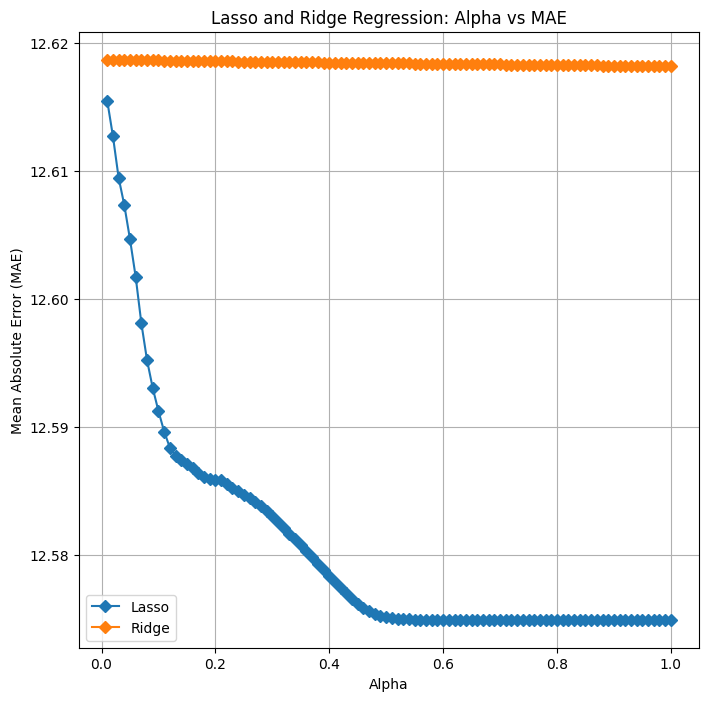

Best Alpha for Lasso: 0.56
Best Alpha for Ridge: 1.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# 피처와 타겟 설정
X = train.drop('Target', axis=1)
y = train['Target']

# 훈련 세트와 검증 세트 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 피처 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# alpha 값을 수동으로 정의 (예: 0.01, 0.1, 1.0 등)
alpha_space = np.arange(0.01, 1.01, 0.01)

# Lasso 모델에 대한 교차 검증 수행
lasso_scores = []
lasso = Lasso()  # normalize=True 제거
for alpha in alpha_space:
    lasso.alpha = alpha
    # 10-fold cross-validation을 통한 성능 평가
    val = np.mean(cross_val_score(lasso, X_train_scaled, y_train, cv=10, scoring='neg_mean_absolute_error'))
    lasso_scores.append(-val)  # MAE는 음수로 반환되므로 부호를 변경

# Ridge 모델에 대한 교차 검증 수행
ridge_scores = []
ridge = Ridge()  # normalize=True 제거
for alpha in alpha_space:
    ridge.alpha = alpha
    val = np.mean(cross_val_score(ridge, X_train_scaled, y_train, cv=10, scoring='neg_mean_absolute_error'))
    ridge_scores.append(-val)  # MAE는 음수로 반환되므로 부호를 변경

# 시각화
plt.figure(figsize=(8, 8))
plt.plot(alpha_space, lasso_scores, marker='D', label="Lasso")
plt.plot(alpha_space, ridge_scores, marker='D', label="Ridge")
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Lasso and Ridge Regression: Alpha vs MAE')
plt.legend()
plt.grid()
plt.show()

# 최적의 alpha 값 찾기
best_alpha_lasso = alpha_space[np.argmin(lasso_scores)]
best_alpha_ridge = alpha_space[np.argmin(ridge_scores)]
print(f'Best Alpha for Lasso: {best_alpha_lasso}')
print(f'Best Alpha for Ridge: {best_alpha_ridge}')
